# Final Proyect 

In [1]:
from ultralytics import YOLO
import glob
from pathlib import Path

import pandas as pd
import os, cv2, re
import numpy as np
import xml.etree.ElementTree as ET

# Data visualization

Los datos han sido descargados de https://universe.roboflow.com/rjacaac1/ua-detrac-dataset-10k/dataset/2

Estos son archivos txt los cuales estos son los nombres de las columnas en el mismo orden en el que lo encontramos en los archivos

[class_id, center_x, center_y, width, height]

Ahora vamos a visualizar las imagenes que estan en formato jpg. 

- UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/
- UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/

# Data Preprocessing

In [2]:
# Define la ruta raíz donde estás ahora (el punto '.' significa carpeta actual)
# Si ejecutas el script desde fuera, cambia '.' por la ruta completa
dataset_path = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8' 

# Listas para almacenar la información
data = []

# Las carpetas que suele tener YOLOv8 (a veces 'test' no existe, por eso lo comprobaremos)
# splits = ['train', 'valid', 'test']
splits = ['train', 'valid'] # NO EXISTE TEST EN NUESTRA DESCARGA 

for split in splits:
    # Construimos la ruta: ./train/images/*.jpg
    search_path = os.path.join(dataset_path, split, 'images', '*.jpg')
    images = glob.glob(search_path)
    
    # Si la carpeta no existe o está vacía (ej. test), pasamos a la siguiente
    if not images:
        continue

    print(f"Procesando {split}: {len(images)} imágenes encontradas.")

    for img_path in images:
        # 1. Obtener ID de la imagen (nombre del archivo sin extensión)
        filename = os.path.basename(img_path)
        image_id = os.path.splitext(filename)[0]
        
        # 2. Construir la ruta de la etiqueta correspondiente
        # La lógica de YOLO es cambiar /images/ por /labels/ y .jpg por .txt
        label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        
        # Opcional: Verificar si el txt existe (para evitar errores luego)
        # if not os.path.exists(label_path):
        #     label_path = None # O marcar como 'missing'
            
        data.append({
            'image_id': image_id,
            'image_path': img_path,   # Ruta de la imagen
            'label_path': label_path, # Ruta del txt
            'set': split            # 'train', 'valid' o 'test'
        })

# Crear el DataFrame
df = pd.DataFrame(data)

# Muestra las primeras filas
print("\n--- Primeras 5 filas del DataFrame ---")
print(df.head())

# Muestra el conteo por set para verificar
print("\n--- Resumen del Dataset ---")
print(df['set'].value_counts())

Procesando train: 9316 imágenes encontradas.
Procesando valid: 500 imágenes encontradas.

--- Primeras 5 filas del DataFrame ---
                                            image_id  \
0  MVI_20052_img00158_jpg.rf.50ed1502ff234681b511...   
1  MVI_39271_img00494_jpg.rf.1184116be16d110fb166...   
2  MVI_39361_img01720_jpg.rf.c1a0eb49147326a4b1bc...   
3  MVI_39401_img00559_jpg.rf.73be5b65ab57747a13c3...   
4  MVI_39771_img00025_jpg.rf.cc566f41b407cf2eb0ba...   

                                          image_path  \
0  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
1  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
2  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
3  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
4  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   

                                          label_path    set  
0  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...  train  
1  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...  train  
2  ./UA-DET

In [4]:
df.columns

Index(['image_id', 'image_path', 'label_path', 'set'], dtype='object')

# Training of the model 

Primero vamos a usar k-fold para el training y validar el modelo ya que tenemos muchas imagenes de train pero no tenemos muchas de validación y las imagenes de train es un video continuo

### K 

In [2]:
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}

In [3]:
import os
import glob
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from collections import Counter

# --- CONFIGURACIÓN ---
dataset_path = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8'
num_folds = 5

# TUS CLASES REALES
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}

# --- MAPA DE PRIORIDADES ---
# Clave: ID de la clase (0, 1, 2, 3)
# Valor: Nivel de Prioridad (Menor número = Más importante/Raro)
priority_map = {
    0: 0,  # Bus   -> Prioridad MÁXIMA (Top)
    2: 1,  # Truck -> Prioridad MEDIA (Igual que Van)
    3: 1,  # Van   -> Prioridad MEDIA (Igual que Truck)
    1: 2   # Car   -> Prioridad BAJA (Fondo/Común)
}

print("Recolectando imágenes y calculando prioridades...")

# Búsqueda recursiva de imágenes
images = glob.glob(os.path.join(dataset_path, '**', '*.jpg'), recursive=True)
data = []

for img_path in images:
    # Convertir ruta de imagen a etiqueta
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    
    assigned_priority = 99 # Default (vacío)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
        if lines:
            # Sacar IDs únicos presentes en la foto
            classes_in_img = set([int(line.split()[0]) for line in lines])
            
            # Buscar la MEJOR prioridad presente en la foto (el valor más bajo del mapa)
            best_prio = 99
            for c in classes_in_img:
                # Si la clase está en el mapa, sacamos su prioridad, si no, damos 10
                p = priority_map.get(c, 10) 
                if p < best_prio:
                    best_prio = p
            
            assigned_priority = best_prio
        else:
             assigned_priority = 99 # Etiqueta vacía
    else:
        assigned_priority = 99 # No existe txt

    data.append({
        'path': os.path.abspath(img_path), 
        'priority_group': assigned_priority
    })

df = pd.DataFrame(data)

# Filtrar imágenes vacías o sin clases de interés (si quisieras)
df = df[df['priority_group'] != 99]

print(f"Imágenes válidas: {len(df)}")
print("\n--- Distribución de grupos para Stratified K-Fold ---")
# Deberías ver 3 grupos principales: 0 (Bus), 1 (Truck+Van), 2 (Car)
print(df['priority_group'].value_counts().sort_index())
print("Leyenda: 0=Bus, 1=Truck/Van, 2=Car")

# --- GENERAR K-FOLDS ---
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

os.makedirs('folds', exist_ok=True)
fold_yamls = []

X = df['path']
y = df['priority_group'] # Estratificamos basándonos en este grupo de prioridad

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Obtener rutas
    train_files = df.iloc[train_idx]['path'].tolist()
    val_files = df.iloc[val_idx]['path'].tolist()
    
    # Rutas absolutas para los txt
    train_txt = os.path.abspath(f'folds/train_fold_{fold_idx}.txt')
    val_txt = os.path.abspath(f'folds/val_fold_{fold_idx}.txt')
    
    # Guardar archivos de lista de imágenes
    with open(train_txt, 'w') as f:
        f.write('\n'.join(train_files))
    with open(val_txt, 'w') as f:
        f.write('\n'.join(val_files))
        
    # Crear YAML
    yaml_content = {
        'path': os.path.abspath(dataset_path), # Root dir opcional
        'train': train_txt,
        'val': val_txt,
        'names': class_names
    }
    
    yaml_filename = f'folds/fold_{fold_idx}.yaml'
    with open(yaml_filename, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
        
    fold_yamls.append(yaml_filename)

print(f"\n¡Listo! Se han generado {num_folds} folds equilibrados.")
print(f"Archivos YAML guardados en: {os.path.abspath('folds')}")

Recolectando imágenes y calculando prioridades...
Imágenes válidas: 9816

--- Distribución de grupos para Stratified K-Fold ---
priority_group
0    1444
1    5288
2    3084
Name: count, dtype: int64
Leyenda: 0=Bus, 1=Truck/Van, 2=Car

¡Listo! Se han generado 5 folds equilibrados.
Archivos YAML guardados en: /home/alumno/Desktop/datos/Computer_vision/final_project/folds


In [ ]:
from ultralytics import YOLO
import numpy as np
import torch

# --- CONFIGURACIÓN ---
num_folds = 5
epochs = 10
batch_size = 16
img_size = 640
model_name = 'yolov8n.pt' 

# Listas para guardar resultados
map50_results = []
map50_95_results = []

print(f"--- INICIANDO CROSS-VALIDATION K={num_folds} (Deterministic) ---")

for k in range(num_folds):
    print(f"\nTraining Fold {k+1}/{num_folds}...")
    
    # Cargar modelo limpio
    model = YOLO(model_name)
    
    results = model.train(
        data=f'folds/fold_{k}.yaml', 
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        project='runs/kfold',
        name=f'fold_{k}',
        patience=10,
        verbose=True,
        exist_ok=True,
        
        # --- AJUSTES DE REPRODUCIBILIDAD ---
        seed=42,             # Semilla fija para inicialización
        deterministic=True,  # Fuerza operaciones deterministas en CUDA (un poco más lento, pero exacto)
        workers=4            # Número de hilos para cargar datos (ajusta según tu CPU)
    )
    
    # Validación
    metrics = model.val()
    
    map50_results.append(metrics.box.map50)
    map50_95_results.append(metrics.box.map)

# --- INFORME FINAL ---
print("\n" + "="*40)
print(f"RESUMEN K-FOLD (Avg over {num_folds} folds)")
print("="*40)
for i in range(num_folds):
    print(f"Fold {i}: mAP@50 = {map50_results[i]:.4f} | mAP@50-95 = {map50_95_results[i]:.4f}")

print("-" * 40)
print(f"Promedio mAP@50:    {np.mean(map50_results):.4f}")
print(f"Promedio mAP@50-95: {np.mean(map50_95_results):.4f}")
print("="*40)

--- INICIANDO CROSS-VALIDATION K=5 (Deterministic) ---

Training Fold 1/5...
New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=folds/fold_0.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=tr

In [5]:
# ! uv pip install ultralytics

In [6]:
from fastprogress import progress_bar
import shutil
from ultralytics import YOLO

Analizando la imagen: ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40763_img01723_jpg.rf.eb386af9359bce709946a068e259ba06.jpg

image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40763_img01723_jpg.rf.eb386af9359bce709946a068e259ba06.jpg: 640x640 1 person, 6 cars, 5.3ms
Speed: 2.1ms preprocess, 5.3ms inference, 18.8ms postprocess per image at shape (1, 3, 640, 640)


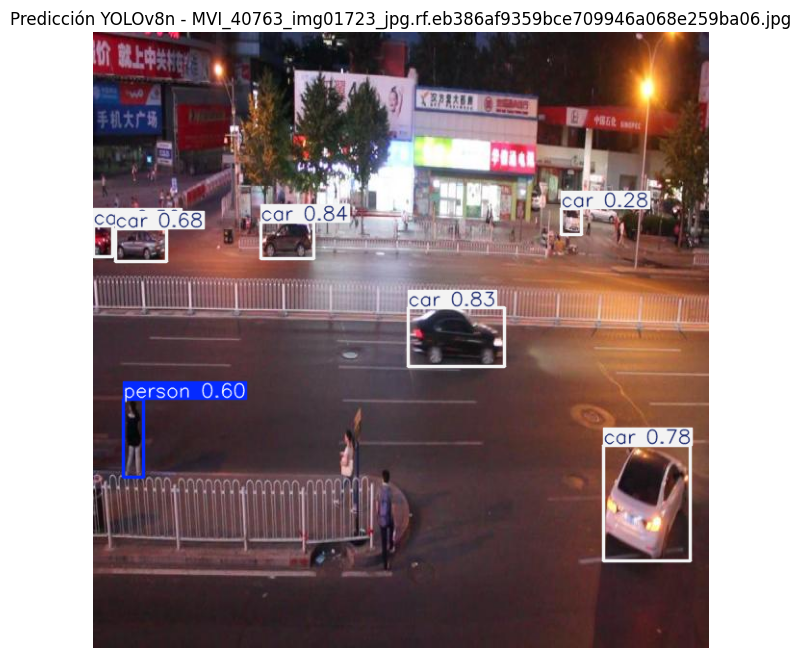

In [7]:
import cv2
import matplotlib.pyplot as plt
import random

# 1. Cargar el modelo pre-entrenado
# 'yolov8n.pt' se descargará solo si no lo tienes.
model = YOLO('yolov8n.pt')

# 2. Preparar una imagen de ejemplo
# Ruta a tus imágenes de validación
ruta_validacion = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images' 

# Listar todos los archivos .jpg en esa carpeta
imagenes_disponibles = [f for f in os.listdir(ruta_validacion) if f.endswith('.jpg')]

# Elegir una al azar
if len(imagenes_disponibles) > 0:
    imagen_elegida = random.choice(imagenes_disponibles)
    ruta_completa_imagen = os.path.join(ruta_validacion, imagen_elegida)
    print(f"Analizando la imagen: {ruta_completa_imagen}")

    # 3. Realizar la predicción
    # YOLOv8 acepta directamente la ruta del archivo (path)
    results = model(ruta_completa_imagen)

    # 4. Visualizar los resultados
    # results[0].plot() devuelve la imagen pintada en formato BGR (Blue-Green-Red)
    annotated_image_bgr = results[0].plot()

    # Matplotlib necesita RGB, así que convertimos los colores para que no se vea azulado
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image_rgb)
    plt.title(f"Predicción YOLOv8n - {imagen_elegida}")
    plt.axis('off')
    plt.show()

else:
    print(f"No encontré imágenes .jpg en {ruta_validacion}")

Now we can <span style="color:#D52B29">train the model</span>. To keep things simple, we will leave the <span style="color:#D52B29">configuration mostly at default</span>, except for the <span style="color:#D52B29">image size</span>, which will be set to <span style="color:#D52B29">384</span> to stay <span style="color:#D52B29">aligned with previous experiments</span>.

**Hacemos el entrenamiento de Yolov8**

In [8]:
# 1. Load the pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# 2. Start training using the path to the YAML configuration file
#    Make sure you have previously executed the dataset conversion script.
# results = model.train(
#     data='./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/data.yaml',  # Path to your YAML file ( ¿Pilla directamente las clases no ?)
#     epochs=15,
#     imgsz=384, # Porque has cogido esta dimentsion ?? ¿Es porque yolo necesita ese size o hemos cogido uno cualquiera ?
#     name='yolov8n_data_prueba_inicial'
# )
results = model.train(
    data='./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/data.yaml',
    epochs=15,
    imgsz=384,
    name='yolov8n_reproducible',
    
    # --- PARÁMETROS DE REPRODUCIBILIDAD ---
    seed=42,             # Fija la semilla 
    deterministic=True,  # Obliga a usar algoritmos deterministas
    workers=2            # (Opcional) Reduce los hilos de carga de datos a 1 para evitar aleatoriedad en el orden de carga
)
#SMALL SON LAS 10000 IMAGENES 

New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=384, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=

In [ ]:
# import matplotlib.pyplot as plt

# # 1. Datos extraídos MANUALMENTE de tu log
# data = {
#     'Clase': ['Bus', 'Car', 'Truck', 'Van', 'All (Global)'],
#     'Precision': [0.954, 0.943, 0.861, 0.940, 0.924], # Columna Box(P)
#     'Recall':    [0.873, 0.925, 0.789, 0.961, 0.887]  # Columna R
# }

# # Colores para cada punto
# colors = ['#e6194b', '#3cb44b', '#4363d8', '#f58231', 'black']
# markers = ['o', 's', '^', 'D', '*']

# plt.figure(figsize=(10, 8))

# # 2. Dibujar los puntos
# for i, clase in enumerate(data['Clase']):
#     p = data['Precision'][i]
#     r = data['Recall'][i]
    
#     # El punto
#     plt.scatter(r, p, color=colors[i], s=150, label=clase, marker=markers[i], zorder=5)
    
#     # Una línea punteada hacia los ejes para ver mejor la posición
#     plt.plot([r, r], [0, p], color=colors[i], linestyle='--', alpha=0.3)
#     plt.plot([0, r], [p, p], color=colors[i], linestyle='--', alpha=0.3)
    
#     # Etiqueta con el valor exacto
#     plt.text(r + 0.01, p + 0.01, f"{clase}\n(R:{r}, P:{p})", fontsize=9)

# # 3. Configuración del gráfico
# plt.title('Rendimiento por Clase (Datos de tu Log)', fontsize=16)
# plt.xlabel('Recall (Sensibilidad) - ¿Cuántos encontramos?', fontsize=12)
# plt.ylabel('Precision (Precisión) - ¿Cuántos acertamos?', fontsize=12)
# plt.xlim(0.7, 1.0) # Hacemos zoom en la zona alta (ajusta a 0.0 si quieres ver todo)
# plt.ylim(0.7, 1.0)
# plt.grid(True, which='both', linestyle='--', alpha=0.5)
# plt.legend(loc='lower left')

# # Mostrar el "área ideal" (esquina superior derecha)
# plt.axvline(x=1, color='gray', linestyle='-', alpha=0.2)
# plt.axhline(y=1, color='gray', linestyle='-', alpha=0.2)

# plt.show()

Sacar los ejemplos que peor clasifica y ver el porque

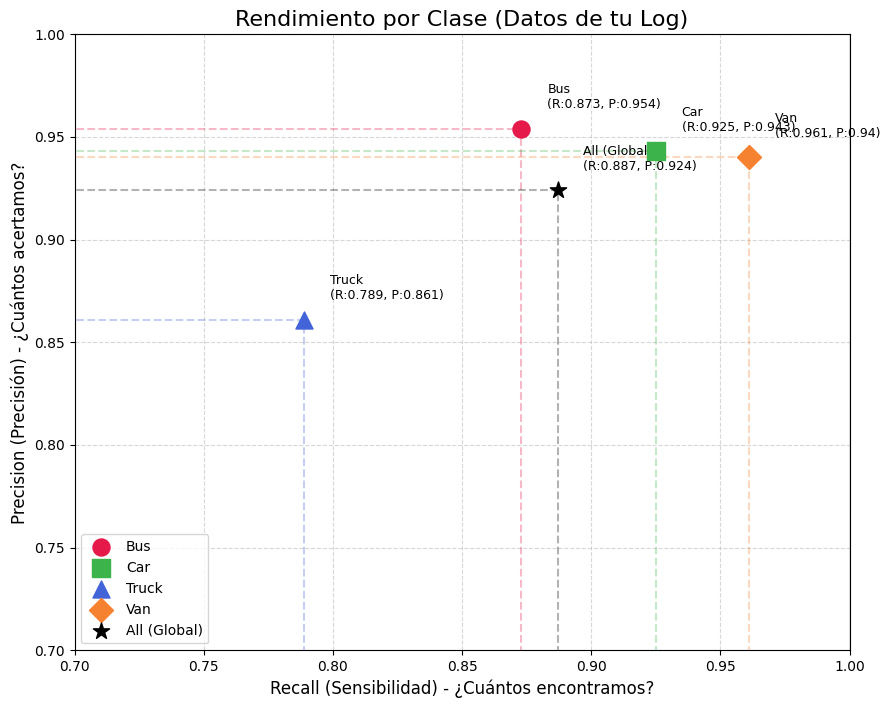

In [9]:
import matplotlib.pyplot as plt

# 1. Datos extraídos MANUALMENTE de tu log
data = {
    'Clase': ['Bus', 'Car', 'Truck', 'Van', 'All (Global)'],
    'Precision': [0.954, 0.943, 0.861, 0.940, 0.924], # Columna Box(P)
    'Recall':    [0.873, 0.925, 0.789, 0.961, 0.887]  # Columna R
}

# Colores para cada punto
colors = ['#e6194b', '#3cb44b', '#4363d8', '#f58231', 'black']
markers = ['o', 's', '^', 'D', '*']

plt.figure(figsize=(10, 8))

# 2. Dibujar los puntos
for i, clase in enumerate(data['Clase']):
    p = data['Precision'][i]
    r = data['Recall'][i]
    
    # El punto
    plt.scatter(r, p, color=colors[i], s=150, label=clase, marker=markers[i], zorder=5)
    
    # Una línea punteada hacia los ejes para ver mejor la posición
    plt.plot([r, r], [0, p], color=colors[i], linestyle='--', alpha=0.3)
    plt.plot([0, r], [p, p], color=colors[i], linestyle='--', alpha=0.3)
    
    # Etiqueta con el valor exacto
    plt.text(r + 0.01, p + 0.01, f"{clase}\n(R:{r}, P:{p})", fontsize=9)

# 3. Configuración del gráfico
plt.title('Rendimiento por Clase (Datos de tu Log)', fontsize=16)
plt.xlabel('Recall (Sensibilidad) - ¿Cuántos encontramos?', fontsize=12)
plt.ylabel('Precision (Precisión) - ¿Cuántos acertamos?', fontsize=12)
plt.xlim(0.7, 1.0) # Hacemos zoom en la zona alta (ajusta a 0.0 si quieres ver todo)
plt.ylim(0.7, 1.0)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='lower left')

# Mostrar el "área ideal" (esquina superior derecha)
plt.axvline(x=1, color='gray', linestyle='-', alpha=0.2)
plt.axhline(y=1, color='gray', linestyle='-', alpha=0.2)

plt.show()


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40241_img00487_jpg.rf.dd22ab88cb8f840d7107e87ce61e477d.jpg: 384x384 5 cars, 2 trucks, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 384)


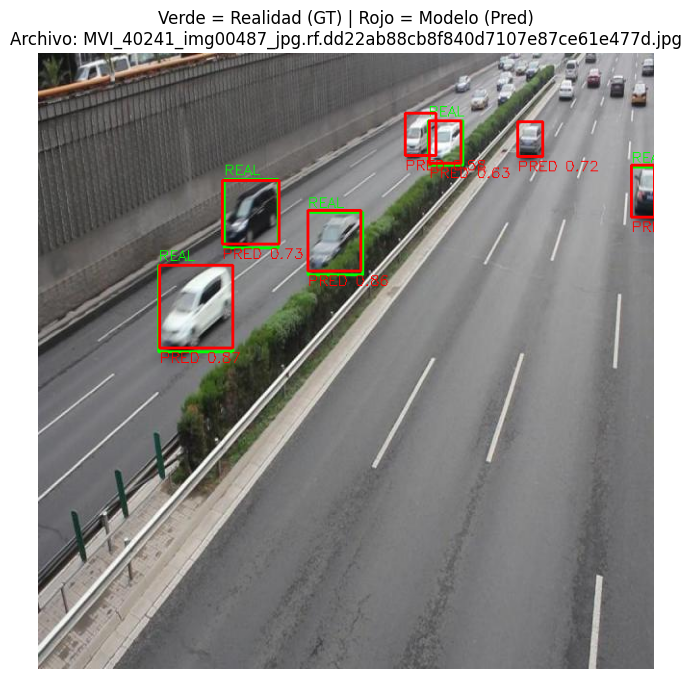


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40244_img00639_jpg.rf.94df73fddf727992fffd0faff4289c32.jpg: 384x384 10 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 384)


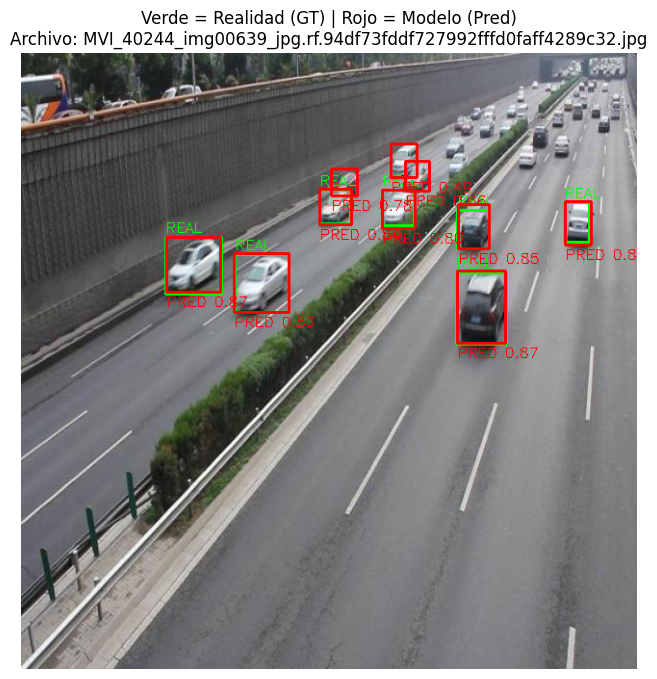


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40711_img00669_jpg.rf.69bfb9c81c8af68b09aeeda7b147f7ca.jpg: 384x384 1 bus, 11 cars, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 384)


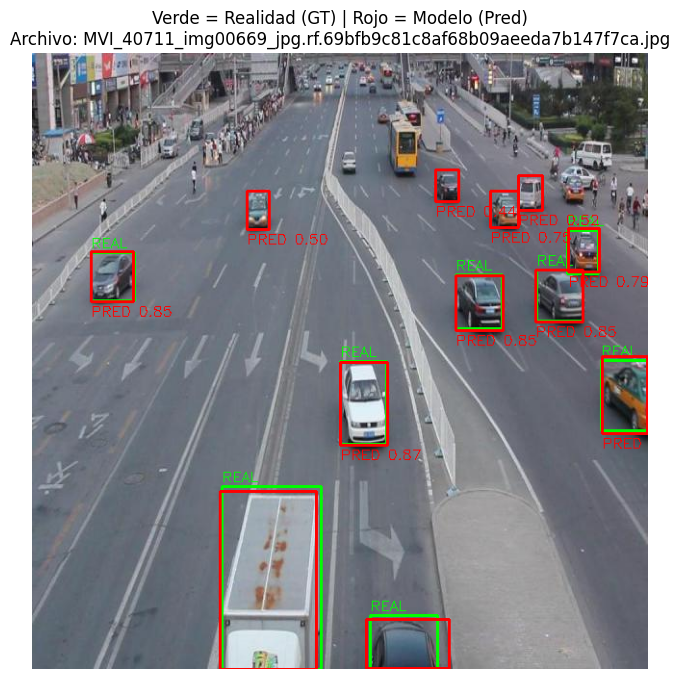


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40712_img01256_jpg.rf.7c8fe67a385ce7887002226f9ccb50c2.jpg: 384x384 10 cars, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 384)


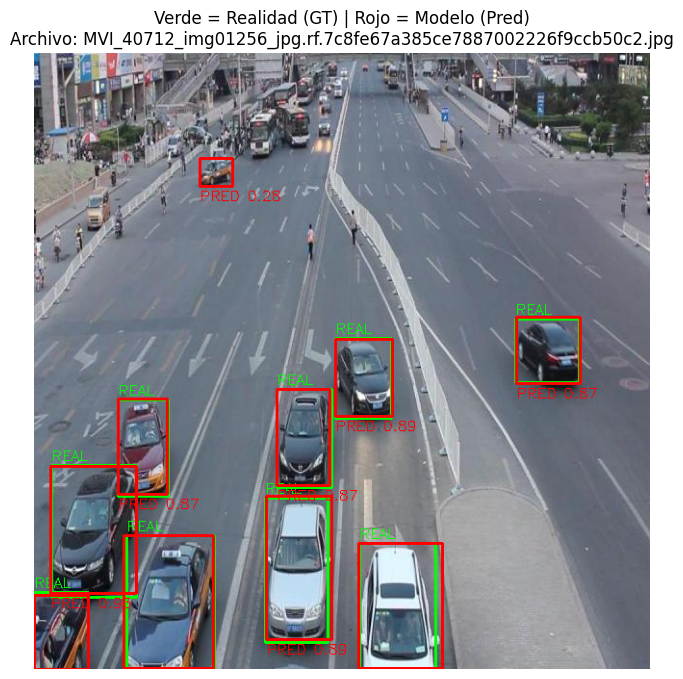


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40732_img00703_jpg.rf.1258bcbed3a471b0a30eb634e5531b2d.jpg: 384x384 7 cars, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 384)


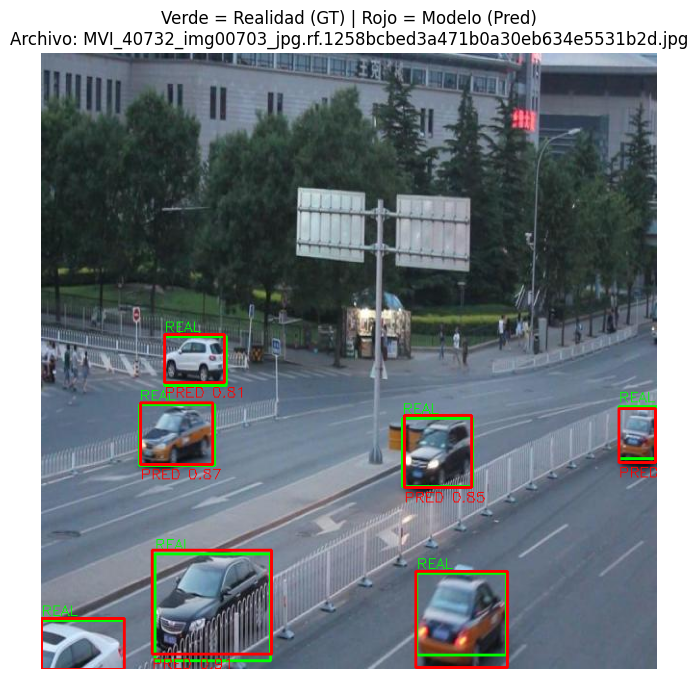


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40732_img01079_jpg.rf.22e3f0c360b78b81bca9a0463a3ec02c.jpg: 384x384 4 cars, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 384)


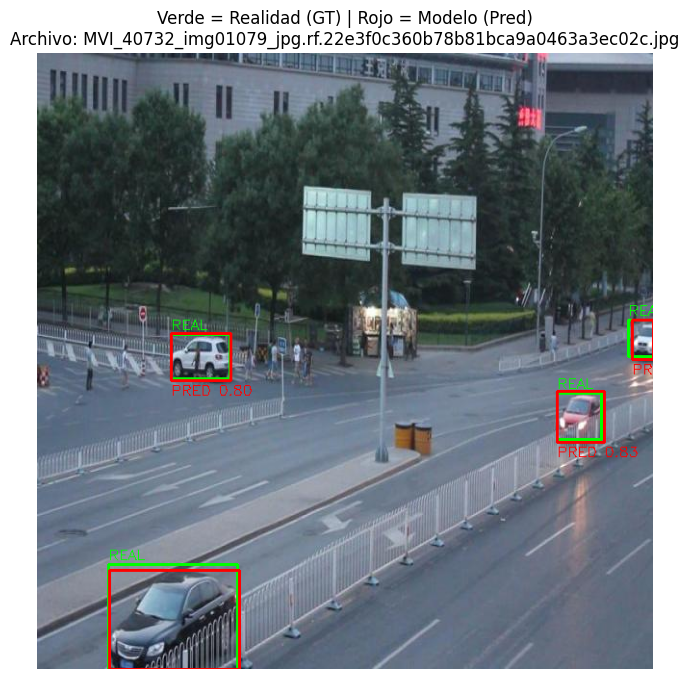


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40743_img00265_jpg.rf.f4d0352107053a9a88039b4028fe8c1d.jpg: 384x384 7 cars, 1 van, 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 384)


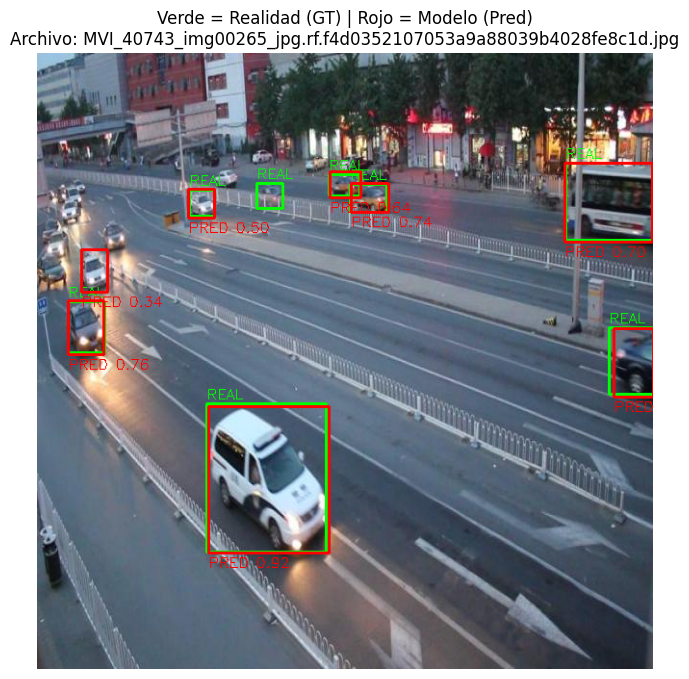


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40752_img00364_jpg.rf.19508a6d3cc69d09dac5aa832ca5b802.jpg: 384x384 8 cars, 2 trucks, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 384)


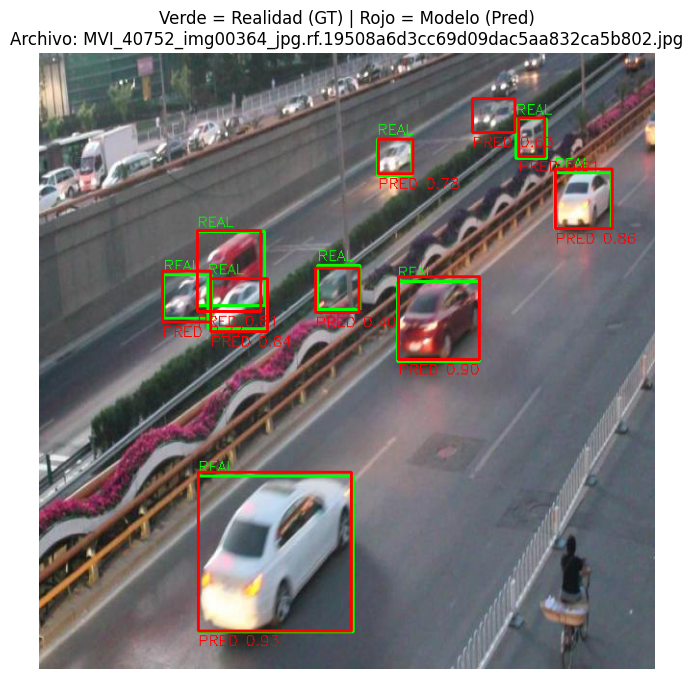


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40752_img01308_jpg.rf.2aafb982444f2d23325b76dc1055b282.jpg: 384x384 10 cars, 4 trucks, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 384)


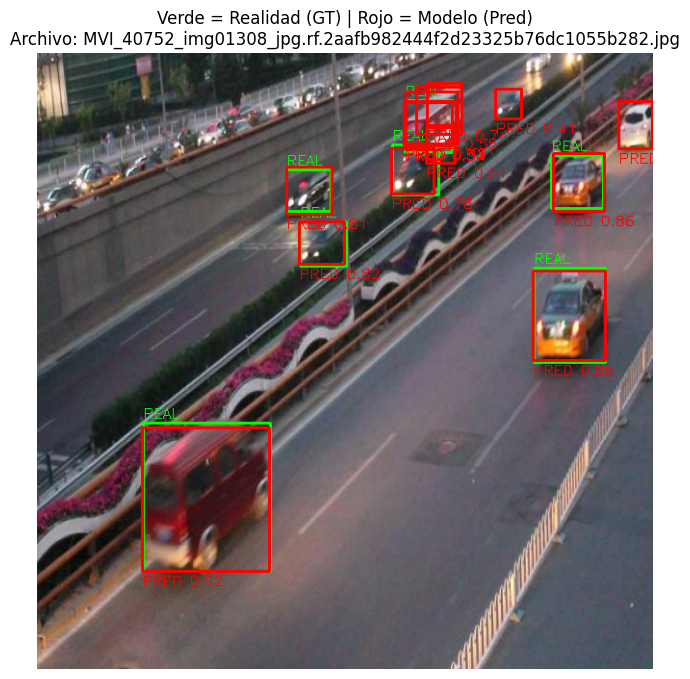


image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40761_img01172_jpg.rf.ea2b7936e8c68ff23e22ab0dd8466715.jpg: 384x384 1 car, 2 vans, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 384)


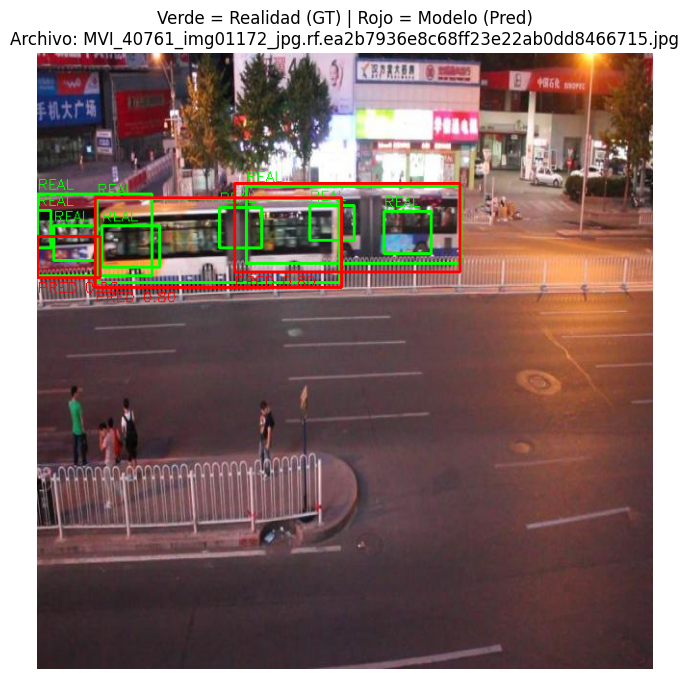

In [10]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import glob

# --- CONFIGURACIÓN ---
model_path = '/home/alumno/Desktop/datos/Computer_vision/final_project/runs/detect/yolov8n_reproducible/weights/best.pt'
data_dir = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid' # Asegúrate que apunta a tu carpeta valid

# Cargar modelo
model = YOLO(model_path)

# Buscar imágenes y etiquetas
img_paths = glob.glob(os.path.join(data_dir, 'images', '*.jpg'))
# Vamos a mirar solo 10 imágenes aleatorias para no saturar, o puedes quitar el slice [:10]
img_paths = img_paths[:10] 

def parse_label(label_path, w, h):
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                # Desnormalizar
                l = int((x - bw/2) * w)
                t = int((y - bh/2) * h)
                r = int((x + bw/2) * w)
                b = int((y + bh/2) * h)
                boxes.append((l, t, r, b, int(cls)))
    return boxes

for img_file in img_paths:
    # 1. Leer imagen
    img = cv2.imread(img_file)
    h, w, _ = img.shape
    
    # 2. Obtener Ground Truth (VERDE)
    label_file = img_file.replace('/images/', '/labels/').replace('.jpg', '.txt')
    gt_boxes = parse_label(label_file, w, h)
    
    # Dibujar Ground Truth (Verde finito)
    for box in gt_boxes:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        cv2.putText(img, "REAL", (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # 3. Obtener Predicción del Modelo (ROJO)
    results = model(img_file, conf=0.25) # conf=0.25 es el estándar
    for r in results:
        boxes = r.boxes
        for box in boxes:
            b = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf)
            cls = int(box.cls)
            
            # Dibujar Predicción (Rojo)
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
            cv2.putText(img, f"PRED {conf:.2f}", (b[0], b[3]+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # 4. Mostrar comparación
    # Convertir a RGB para matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f"Verde = Realidad (GT) | Rojo = Modelo (Pred)\nArchivo: {os.path.basename(img_file)}")
    plt.axis('off')
    plt.show()

Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 217.0±37.9 MB/s, size: 53.5 KB)
val: Scanning /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 815.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 11.5it/s 2.8s0.1s
                   all        500       4845      0.865      0.838      0.896      0.734
                   bus         94         96      0.886       0.74      0.872       0.68
                   car        500       4103      0.888      0.928      0.957       0.77
                 truck        135        188      0.791      0.729      0.788      0.65

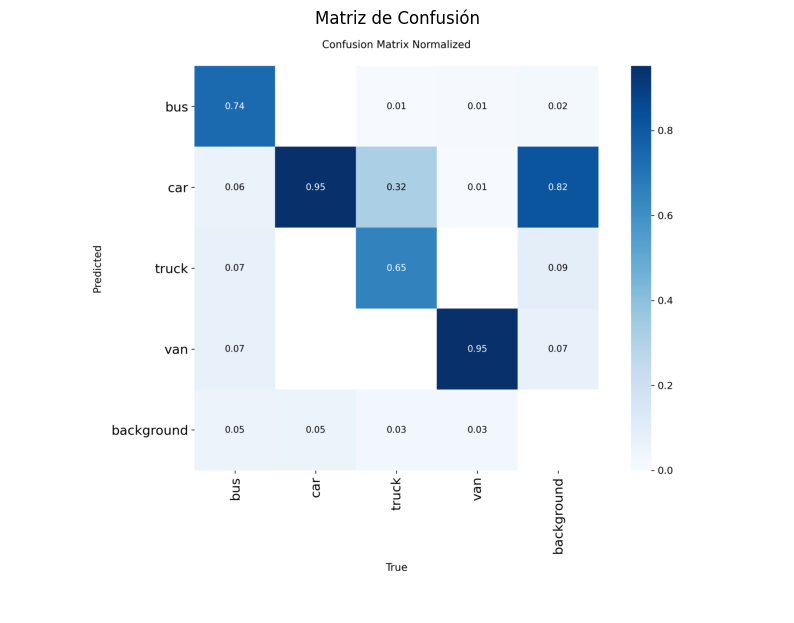

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# 1. Cargar tu modelo entrenado
model_path = '/home/alumno/Desktop/datos/Computer_vision/final_project/runs/detect/yolov8n_reproducible/weights/best.pt'
model = YOLO(model_path)

# 2. Ejecutar validación (Esto genera la Matriz de Confusión nueva)
results = model.val(data='./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/data.yaml', plots=True)

# 3. Mostrar la imagen generada
# YOLO suele guardar esto en runs/detect/val (o val2, val3...)
# Vamos a buscar en la carpeta donde se acaban de guardar los resultados
save_dir = results.save_dir # Ruta automática donde YOLO guardó todo
confusion_matrix_path = os.path.join(save_dir, 'confusion_matrix_normalized.png') 

# Si no existe la normalizada, buscamos la normal
if not os.path.exists(confusion_matrix_path):
    confusion_matrix_path = os.path.join(save_dir, 'confusion_matrix.png')

if os.path.exists(confusion_matrix_path):
    img = mpimg.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Matriz de Confusión")
    plt.show()
else:
    print(f"No encontré la imagen en {save_dir}, revisa la carpeta manualmente.")

Explicando detección: Clase car (Conf: 0.86)
Generando 1000 máscaras... (Esto puede tardar dependiendo de tu GPU)


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 82.31it/s]


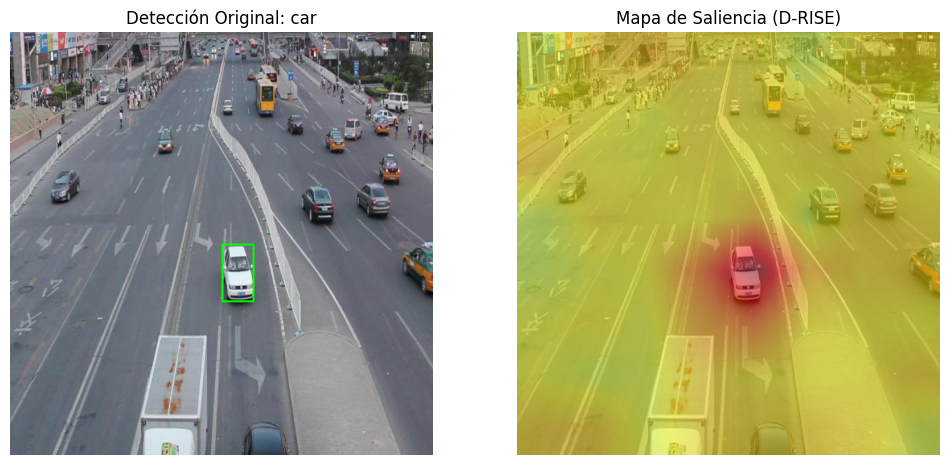

In [5]:
import torch
from tqdm import tqdm

def calculate_iou(box1, box2):
    """Calcula Intersection over Union (IoU) entre dos cajas [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

def generate_mask(img_shape, grid_size=(16, 16), prob=0.5):
    """Genera una máscara binaria aleatoria de baja resolución y la escala"""
    h, w = img_shape[:2]
    # Crear máscara pequeña aleatoria
    mask_small = (np.random.rand(*grid_size) < prob).astype(np.float32)
    # Escalar al tamaño de la imagen con suavizado
    mask = cv2.resize(mask_small, (w, h), interpolation=cv2.INTER_LINEAR)
    return mask

def drise_yolov8(image_path, model_path, num_masks=1000, target_class_id=None):
    # 1. Cargar modelo e imagen
    model = YOLO(model_path)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # 2. Obtener la detección original (Ground Truth para D-RISE)
    results = model(img_rgb, verbose=False)
    
    # Seleccionar la caja con mayor confianza si no se especifica
    best_box = None
    best_conf = -1
    best_cls = -1
    
    # Buscamos la mejor detección original
    if len(results[0].boxes) == 0:
        print("El modelo no detectó nada en la imagen original.")
        return
        
    for box in results[0].boxes:
        cls = int(box.cls)
        conf = float(box.conf)
        # Si el usuario quiere una clase específica (ej: solo 'car'), filtramos
        if target_class_id is not None and cls != target_class_id:
            continue
            
        if conf > best_conf:
            best_conf = conf
            best_box = box.xyxy[0].cpu().numpy() # [x1, y1, x2, y2]
            best_cls = cls

    if best_box is None:
        print(f"No se encontró la clase {target_class_id} en la imagen.")
        return

    print(f"Explicando detección: Clase {model.names[best_cls]} (Conf: {best_conf:.2f})")
    print(f"Generando {num_masks} máscaras... (Esto puede tardar dependiendo de tu GPU)")

    # 3. Bucle D-RISE
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    for _ in tqdm(range(num_masks)):
        # A. Crear máscara
        mask = generate_mask((h, w), grid_size=(8, 8), prob=0.5)
        
        # B. Aplicar máscara a la imagen
        # Expandimos dims para multiplicar (h, w, 1) * (h, w, 3)
        masked_img = (img_rgb * mask[:, :, np.newaxis]).astype(np.uint8)
        
        # C. Predicción sobre imagen enmascarada
        res_masked = model(masked_img, verbose=False, conf=0.1) # Bajamos conf para pillar detecciones débiles
        
        # D. Calcular puntuación (Similarity Score)
        score = 0
        for m_box in res_masked[0].boxes:
            m_cls = int(m_box.cls)
            if m_cls != best_cls: continue # Solo nos interesa la misma clase
            
            m_xyxy = m_box.xyxy[0].cpu().numpy()
            m_conf = float(m_box.conf)
            
            iou = calculate_iou(best_box, m_xyxy)
            
            # La puntuación es IoU * Confianza
            # Si el IoU es muy bajo, es que detectó el coche en otro lado, no cuenta
            if iou > 0.5: 
                score = max(score, iou * m_conf)
        
        # E. Acumular en el mapa de calor
        heatmap += mask * score

    # 4. Normalizar y Visualizar
    heatmap = heatmap / heatmap.max()
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    
    # Superponer
    overlay = cv2.addWeighted(img, 0.5, heatmap_color, 0.5, 0)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    # Dibujar caja original en la imagen
    img_box = img_rgb.copy()
    cv2.rectangle(img_box, (int(best_box[0]), int(best_box[1])), 
                  (int(best_box[2]), int(best_box[3])), (0, 255, 0), 2)
    plt.imshow(img_box)
    plt.title(f"Detección Original: {model.names[best_cls]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Mapa de Saliencia (D-RISE)")
    plt.axis('off')
    
    plt.show()

# --- EJECUCIÓN ---
# Ajusta tus rutas aquí
ruta_modelo = '/home/alumno/Desktop/datos/Computer_vision/final_project/runs/detect/yolov8n_reproducible/weights/best.pt'
ruta_imagen = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40711_img00669_jpg.rf.69bfb9c81c8af68b09aeeda7b147f7ca.jpg' # CAMBIA ESTO

# num_masks=1000 es un buen equilibrio. El paper original usa 5000 (más lento, más preciso).
drise_yolov8(ruta_imagen, ruta_modelo, num_masks=1000)

In [9]:
# ==========================================
# CONFIGURACIÓN DE REPRODUCIBILIDAD Y RUTAS
# ==========================================
SEED_VALUE = 42
N_IMAGES_TO_SHOW = 10

# Rutas (Ajustadas a tu estructura anterior)
VALID_DIR = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images'
MODEL_PATH = '/home/alumno/Desktop/datos/Computer_vision/final_project/runs/detect/yolov8n_reproducible/weights/best.pt'
OUTPUT_DIR = './resultados_drise_validacion' # Carpeta nueva para guardar los resultados

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# FIJAR SEMILLAS (Para selección de imágenes y para las máscaras de D-RISE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
print(f"Semilla aleatoria fijada a: {SEED_VALUE}")
# ==========================================


def calculate_iou(box1, box2):
    """Calcula Intersection over Union (IoU) entre dos cajas [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

def generate_mask(img_shape, grid_size=(16, 16), prob=0.5):
    """Genera una máscara binaria aleatoria de baja resolución y la escala"""
    h, w = img_shape[:2]
    # Crear máscara pequeña aleatoria (usará la semilla fijada de numpy)
    mask_small = (np.random.rand(*grid_size) < prob).astype(np.float32)
    # Escalar al tamaño de la imagen con suavizado
    mask = cv2.resize(mask_small, (w, h), interpolation=cv2.INTER_LINEAR)
    return mask

# --- MODIFICACIÓN: Añadido parámetro opcional 'save_path' ---
def drise_yolov8(image_path, model_path, num_masks=1000, target_class_id=None, save_path=None):
    # 1. Cargar modelo e imagen
    # (Cargamos el modelo fuera del bucle principal para eficiencia, lo pasamos como argumento si ya está cargado)
    if isinstance(model_path, str):
        model = YOLO(model_path)
    else:
        model = model_path

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error al leer la imagen: {image_path}")
        return
        
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # 2. Obtener la detección original
    results = model(img_rgb, verbose=False)
    
    best_box = None
    best_conf = -1
    best_cls = -1
    
    if len(results[0].boxes) == 0:
        print(f"SKIP: El modelo no detectó nada en {os.path.basename(image_path)}")
        return
        
    for box in results[0].boxes:
        cls = int(box.cls)
        conf = float(box.conf)
        if target_class_id is not None and cls != target_class_id:
            continue
            
        if conf > best_conf:
            best_conf = conf
            best_box = box.xyxy[0].cpu().numpy()
            best_cls = cls

    if best_box is None:
        print(f"SKIP: No se encontró la clase objetivo en {os.path.basename(image_path)}")
        return

    img_name = os.path.basename(image_path)
    print(f"\nProcesando: {img_name} | Clase: {model.names[best_cls]} (Conf: {best_conf:.2f})")

    # 3. Bucle D-RISE
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    # Usamos leave=False para que la barra de progreso no llene la pantalla en el bucle
    for _ in tqdm(range(num_masks), desc="Generando máscaras", leave=False):
        mask = generate_mask((h, w), grid_size=(8, 8), prob=0.5)
        masked_img = (img_rgb * mask[:, :, np.newaxis]).astype(np.uint8)
        
        # Bajamos un poco el conf para D-RISE
        res_masked = model(masked_img, verbose=False, conf=0.15) 
        
        score = 0
        for m_box in res_masked[0].boxes:
            m_cls = int(m_box.cls)
            if m_cls != best_cls: continue
            
            m_xyxy = m_box.xyxy[0].cpu().numpy()
            m_conf = float(m_box.conf)
            iou = calculate_iou(best_box, m_xyxy)
            
            if iou > 0.5: 
                score = max(score, iou * m_conf)
        
        heatmap += mask * score

    # 4. Normalizar y Visualizar
    heatmap = heatmap / (heatmap.max() + 1e-8) # Evitar división por cero
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.5, heatmap_color, 0.5, 0)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    img_box = img_rgb.copy()
    cv2.rectangle(img_box, (int(best_box[0]), int(best_box[1])), 
                  (int(best_box[2]), int(best_box[3])), (0, 255, 0), 2)
    plt.imshow(img_box)
    plt.title(f"Original: {model.names[best_cls]} ({img_name})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Explicabilidad D-RISE")
    plt.axis('off')
    
    # --- MODIFICACIÓN: Guardar en lugar de mostrar si hay ruta ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close() # Cerrar la figura para liberar memoria
    else:
        plt.show()

# ==========================================
# EJECUCIÓN DEL BUCLE PRINCIPAL
# ==========================================

# 1. Cargar el modelo una sola vez (más eficiente)
print(f"Cargando modelo desde: {MODEL_PATH}")
model = YOLO(MODEL_PATH)

# 2. Buscar todas las imágenes de validación
all_valid_images = glob.glob(os.path.join(VALID_DIR, '*.jpg'))
total_images = len(all_valid_images)
print(f"Se han encontrado {total_images} imágenes en la carpeta de validación.")

if total_images == 0:
    print("Error: No se encontraron imágenes. Revisa la ruta VALID_DIR.")
    exit()

# 3. Seleccionar N imágenes aleatorias de forma reproducible
# Si hay menos de 10, cogemos todas
num_to_select = min(N_IMAGES_TO_SHOW, total_images)
selected_images = random.sample(all_valid_images, num_to_select)

print(f"Se han seleccionado {num_to_select} imágenes aleatorias con semilla {SEED_VALUE}.")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}\n")

# 4. Bucle para procesar cada imagen
for i, img_path in enumerate(selected_images):
    print(f"--- Procesando imagen {i+1}/{num_to_select} ---")
    
    # Crear nombre para el archivo de salida
    filename = os.path.basename(img_path)
    save_name = f"drise_result_{i:02d}_{filename.replace('.jpg', '.png')}"
    final_save_path = os.path.join(OUTPUT_DIR, save_name)
    
    # Ejecutar D-RISE
    # Usamos 500 máscaras para que sea más rápido el bucle de 10 imágenes.
    # Para calidad final, súbelo a 1000 o 2000.
    drise_yolov8(img_path, model, num_masks=2000, save_path=final_save_path)

print(f"\n¡Proceso terminado! Revisa la carpeta: {OUTPUT_DIR}")

Semilla aleatoria fijada a: 42
Cargando modelo desde: /home/alumno/Desktop/datos/Computer_vision/final_project/runs/detect/yolov8n_reproducible/weights/best.pt
Se han encontrado 500 imágenes en la carpeta de validación.
Se han seleccionado 10 imágenes aleatorias con semilla 42.
Los resultados se guardarán en: ./resultados_drise_validacion

--- Procesando imagen 1/10 ---

Procesando: MVI_40773_img00969_jpg.rf.d20653d33f4921c74f6e45aa9e55e7ee.jpg | Clase: car (Conf: 0.92)


--- Procesando imagen 2/10 ---

Procesando: MVI_40793_img01208_jpg.rf.c55b5b358ca99fbaf157208992506f18.jpg | Clase: van (Conf: 0.94)


--- Procesando imagen 3/10 ---

Procesando: MVI_40762_img00054_jpg.rf.a27aa6b74d5b4c8a0c8d16d86c6c0724.jpg | Clase: car (Conf: 0.85)


--- Procesando imagen 4/10 ---

Procesando: MVI_40243_img00145_jpg.rf.cb3c0003628abccc4769962c03814b32.jpg | Clase: car (Conf: 0.89)


--- Procesando imagen 5/10 ---

Procesando: MVI_40743_img00200_jpg.rf.920f96f5f86fcbbee26e35709e88be25.jpg | Clase: van (Conf: 0.93)


--- Procesando imagen 6/10 ---

Procesando: MVI_40793_img00740_jpg.rf.669859ef2b2303d6bc47ca6b3fb57c27.jpg | Clase: car (Conf: 0.93)


--- Procesando imagen 7/10 ---

Procesando: MVI_40761_img00141_jpg.rf.9c9259bd2d2bf0b02180441c05fc5538.jpg | Clase: car (Conf: 0.80)


--- Procesando imagen 8/10 ---

Procesando: MVI_40742_img00018_jpg.rf.c63cc780dc91b97f28e49bb29d430608.jpg | Clase: van (Conf: 0.95)


--- Procesando imagen 9/10 ---

Procesando: MVI_40241_img02050_jpg.rf.0d118304b1caedc9cecbb22bd2591585.jpg | Clase: car (Conf: 0.88)


--- Procesando imagen 10/10 ---

Procesando: MVI_40774_img00903_jpg.rf.e1f5ec8510df3fdb5be2603b1e19d420.jpg | Clase: car (Conf: 0.94)



¡Proceso terminado! Revisa la carpeta: ./resultados_drise_validacion
